In [1]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings
import scipy

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

2022-12-07 17:33:24.252154: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1


2022-12-07 17:33:31.707428: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-07 17:33:31.710977: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-07 17:33:31.741111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:33:31.741395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.755GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-12-07 17:33:31.741448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-07 17:33:31.748563: I tensorflow/stream_executor/platform

In [2]:
#define image dataset 
#why do we rescale?
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='../train',
                                                 shuffle=True,
                                                 target_size=(224,224), 
                                                 class_mode='binary')

image_generator = ImageDataGenerator(rescale=1/255) 

validation_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='../valid',
                                                 shuffle=True,
                                                 target_size=(224,224),
                                                 class_mode='binary')


test_dataset = image_generator.flow_from_directory(
                                                 directory='../test',
                                                 shuffle=False,
                                                 target_size=(224,224), 
                                                 class_mode=None)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.3129 and the standard deviation is 0.2945


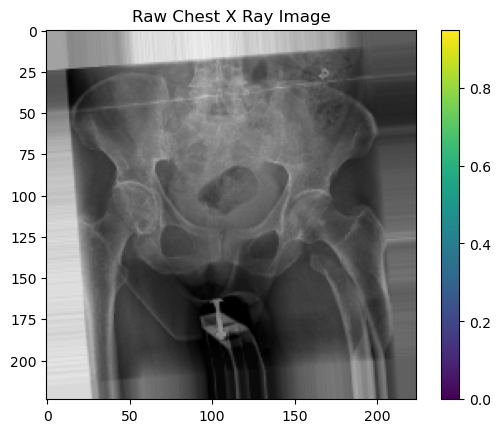

In [3]:
#sns.set_style('white')
generated_image, label = train_dataset.__getitem__(20)
plt.imshow(generated_image[7])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [4]:
model_inception = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in model_inception.layers:
    layer.trainable = False
#x = Flatten()(model_inception.output)

tf.random.set_seed(150)

model = tf.keras.models.Sequential([
    model_inception,
    GlobalAveragePooling2D(),    
    Dense(512,activation="relu"),
    Dropout(0.4),
    # Dense(256,activation="relu"),
    # Dropout(0.4),
    Dense(128, activation='swish'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(),
              loss="binary_crossentropy",
              metrics=['accuracy'])

2022-12-07 17:33:47.196298: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 17:33:47.197197: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-07 17:33:47.197532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-07 17:33:47.197829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.755GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 22,917,665
Trainable params: 1,114,881
Non-trainable params: 21,802,784
____________________________________

In [6]:
# prediction = Dense(1, activation='sigmoid')(x)

# modelinception = Model(inputs=model_inception.input, outputs=prediction)

# modelinception.compile(optimizer='adam',
# loss=tensorflow.losses.BinaryCrossentropy(),
# metrics=[keras.metrics.AUC(name='auc'),'acc'])

# #callback = keras.callbacks.EarlyStopping(monitor='val_loss',
# #                                            patience=8,
# #                                            restore_best_weights=True

In [7]:
model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

2022-12-07 17:38:20.484739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-07 17:38:20.485131: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz


Epoch 1/10


2022-12-07 17:38:23.715966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-07 17:38:31.330677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-12-07 17:43:51.898799: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-12-07 17:43:51.990475: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


82/82 [==============================] - 862s 6s/step - loss: 1053.3449 - accuracy: 0.6472 - val_loss: 701.7945 - val_accuracy: 0.7966
Epoch 2/10
82/82 [==============================] - 390s 5s/step - loss: 593.4397 - accuracy: 0.7238 - val_loss: 992.3467 - val_accuracy: 0.5563
Epoch 3/10
82/82 [==============================] - 402s 5s/step - loss: 670.9742 - accuracy: 0.7250 - val_loss: 203.5383 - val_accuracy: 0.7989
Epoch 4/10
54/82 [==================>...........] - ETA: 1:45 - loss: 272.9489 - accuracy: 0.7066

In [7]:
model.evaluate(test_dataset)

27/27 [==============================] - 167s 6s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]